In [11]:
import numpy as np 
import pandas as pd
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy.stats import f_oneway
import pandas as pd
import datetime
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [12]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [13]:
# 데이터 불러오기
past_sales = pd.read_csv('C:/Users/rlaeo/OneDrive/바탕 화면/rossmann.csv')
store = pd.read_csv('C:/Users/rlaeo/OneDrive/바탕 화면/store.csv')

# 데이터 제거
store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)

# 데이터 병합
data = pd.merge(left = past_sales,right = store, on = 'Store', how = 'right')

# 날짜
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d")
data['Year']=pd.DatetimeIndex(data.Date).year
data['Month']=pd.DatetimeIndex(data.Date).month
data['Day']=pd.DatetimeIndex(data.Date).day
data = data.drop(['Date'],axis=1)

# 데이터 가공 : StateHoliday, Open
data['StateHoliday'] = data['StateHoliday'].replace({0:'d'}) # 0 값은 d로 대체
data['StateHoliday'] = data['StateHoliday'].replace({'0':'d'})# 0 값은 d로 대체
open = data[data['Open']==0].index
data.drop(open,inplace=True)


# 결측값 처리
data = data.dropna(axis=0)

# store,open 이름 제거
data = data.drop(['Store'],axis=1)
data = data.drop(['Open'],axis=1)

# 데이터 분리(수치형, 범주형)
digital_cols = ['Sales', 'Customers', 'CompetitionDistance', 'Year','Month', 'Day']
digital_data = data[digital_cols]
digital_data = pd.DataFrame(digital_data.values, columns = digital_cols)
digital_data
# 표준화
scaler = MinMaxScaler().fit(digital_data)
digital_data = pd.DataFrame(scaler.transform(digital_data),index = digital_data.index, columns = digital_cols)

categorey_clos = data.columns.drop(digital_cols)
categorey_data = data[categorey_clos]
categorey_data = pd.DataFrame(categorey_data.values, columns = categorey_clos)

# 인코딩
onehotencoding_cols = ['StateHoliday', 'StoreType', 'Assortment', 'DayOfWeek']
categorey_data = pd.get_dummies(data=categorey_data, columns=onehotencoding_cols)


# 데이터 병합
data = pd.concat([digital_data, categorey_data], axis = 1)

# 형 통일
data = data.astype({'Promo2':'int', 'StateHoliday_b':'int', 'StateHoliday_c':'int', 'StateHoliday_d':'int', 'StoreType_a':'int', 'StoreType_b':'int', 'StoreType_c':'int', 'StoreType_d':'int'})
data = data.astype({'Assortment_a':'int', 'Assortment_b':'int', 'Assortment_c':'int', 'DayOfWeek_1':'int', 'DayOfWeek_2':'int', 'DayOfWeek_3':'int', 'DayOfWeek_4':'int', 'DayOfWeek_5':'int', 'DayOfWeek_6':'int', 'DayOfWeek_7':'int'})

pd.options.display.max_columns = None
data['StateHoliday_a'] = data['StateHoliday_a'].replace({True: 1, False: 0})
data

C:\Users\rlaeo\AppData\Local\Temp\ipykernel_22312\180076725.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  past_sales = pd.read_csv('C:/Users/rlaeo/OneDrive/바탕 화면/rossmann.csv')


,Sales,Customers,CompetitionDistance,Year,Month,Day,Promo,SchoolHoliday,Promo2,StateHoliday_a,StateHoliday_b,StateHoliday_c,StateHoliday_d,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7
0,0.126664,0.075122,0.016482,1.0,0.545455,1.000000,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0
1,0.120815,0.073904,0.016482,1.0,0.545455,0.966667,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0
2,0.115087,0.070790,0.016482,1.0,0.545455,0.933333,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0
3,0.120599,0.075799,0.016482,1.0,0.545455,0.900000,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0
4,0.146856,0.082837,0.016482,1.0,0.545455,0.866667,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842201,0.166181,0.063752,0.070280,0.0,0.000000,0.200000,1,1,1,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0
842202,0.114823,0.045885,0.070280,0.0,0.000000,0.133333,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0
842203,0.109263,0.044126,0.070280,0.0,0.000000,0.100000,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0
842204,0.103415,0.040606,0.070280,0.0,0.000000,0.066667,0,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0


In [14]:
target_col = 'Sales'
features_cols = data.columns.drop(target_col)        
features = data[features_cols]
target = data[target_col]
target = pd.DataFrame(target.values.reshape(-1,1))
features = features.values
target = target.values

In [15]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.4, shuffle=True)
x_test,x_valid,y_test,y_valid = train_test_split(x_test, y_test, test_size=0.5, shuffle=False)

In [16]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_valid = x_valid.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
y_valid = y_valid.astype(np.float32)
print('train_data의 row : %s, column : %s'%(x_train.shape[0],x_train.shape[1]))
print('test_data의 row : %s, column : %s'%(x_test.shape[0],x_test.shape[1]))
print('val_data의 row : %s, column : %s'%(x_valid.shape[0],x_valid.shape[1]))
scaler = MinMaxScaler()
scaler.fit(x_train)
scaler.fit(x_test)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_valid = scaler.transform(x_valid)


train_data의 row : 505323, column : 26
test_data의 row : 168441, column : 26
val_data의 row : 168442, column : 26


In [17]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(256,input_dim = x_train.shape[1],activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(256,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(256,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(128,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam',
             loss='mse',
             metrics=['mean_absolute_error'])

model_path = 'C:/project/rossmann-store-sales'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path , monitor='val_mean_absolute_error', verbose=1, save_best_only=True)
# early_stopping = EarlyStopping(monitor='val_loss', patience=6)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               6912      
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                      

In [18]:
early_stopping = EarlyStopping()

start = datetime.datetime.now()

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    batch_size=64,
                    epochs=5,
)
score = model.evaluate(x_valid,y_valid)
print('테스트 값',score[1])
end = datetime.datetime.now()
time = end-start
print("처리시간 : ", time)

Epoch 1/5
7896/7896 [==============================] - 49s 6ms/step - loss: 0.0214 - mean_absolute_error: 0.0635 - val_loss: 0.0013 - val_mean_absolute_error: 0.0266
Epoch 2/5
7896/7896 [==============================] - 44s 6ms/step - loss: 0.0013 - mean_absolute_error: 0.0268 - val_loss: 9.2950e-04 - val_mean_absolute_error: 0.0215
Epoch 3/5
7896/7896 [==============================] - 44s 6ms/step - loss: 9.6364e-04 - mean_absolute_error: 0.0229 - val_loss: 9.6121e-04 - val_mean_absolute_error: 0.0201
Epoch 4/5
7896/7896 [==============================] - 45s 6ms/step - loss: 9.0228e-04 - mean_absolute_error: 0.0222 - val_loss: 0.0010 - val_mean_absolute_error: 0.0206
Epoch 5/5
5264/5264 [==============================] - 8s 1ms/step - loss: 0.0011 - mean_absolute_error: 0.0208
테스트 값 0.020792024210095406
처리시간 :  0:03:53.537695


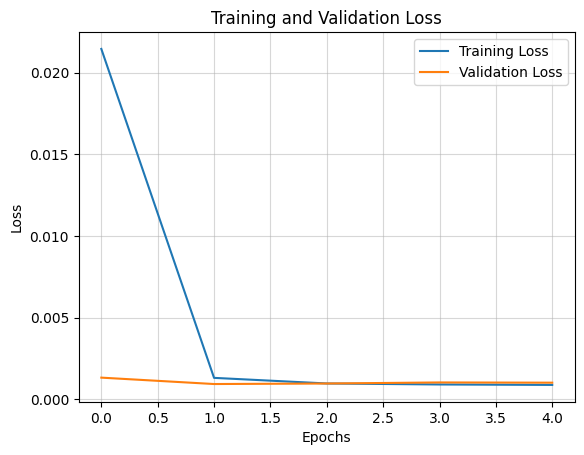

5264/5264 [==============================] - 6s 1ms/step - loss: 0.0010 - mean_absolute_error: 0.0207

 Test Accuracy: 0.0207


In [21]:
import matplotlib.pyplot as plt
# 손실 그래프
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 그리드 추가
plt.grid(True, linestyle='-', alpha=0.5)

plt.show()
print("\n Test Accuracy: %.4f" %(model.evaluate(x_test,y_test)[1]))

In [20]:
y_pred = model.predict(x_test)

def RMSE(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))
MAE =  mean_absolute_error(y_test, y_pred)
MSE =  mean_squared_error(y_test, y_pred)
# R2 값을 계산
r2_value = r2_score(y_test, y_pred)
RMSE = RMSE(y_test, y_pred)
print("MAE 값", MAE)
print("MSE 값", MSE)
print("RMSE 값", RMSE)
print("R2 값:", r2_value)


5264/5264 [==============================] - 6s 1ms/step
MAE 값 0.02069065
MSE 값 0.0010125553
RMSE 값 0.031820673
R2 값: 0.8183660741026857
